<a href="https://colab.research.google.com/github/DM2003/DEEP-LEARNING-PROJECTS/blob/main/FILTERS_RANDOM_DATASET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***KALMANN FILTER***

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install filterpy
from filterpy.kalman import KalmanFilter
from scipy.signal import butter, filtfilt

In [ ]:
import requests
import zipfile
from io import BytesIO

In [ ]:
# Step 1: Download and Extract the ZIP File
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip'

# Fetch the ZIP file
response = requests.get(url)
with zipfile.ZipFile(BytesIO(response.content)) as z:
    # List all files in the ZIP
    print(z.namelist())

    # Extract the CSV file
    csv_file = [f for f in z.namelist() if f.endswith('.csv')][0]
    with z.open(csv_file) as f:
        df = pd.read_csv(f, sep=';', parse_dates=['Date'], dayfirst=True, usecols=['Date', 'PT08.S1(CO)'])

['AirQualityUCI.csv', 'AirQualityUCI.xlsx']


In [ ]:
# Drop rows with missing values
df = df.dropna()

In [ ]:
# Extract the data
time = pd.to_datetime(df['Date'])
noisy_signal = df['PT08.S1(CO)'].values

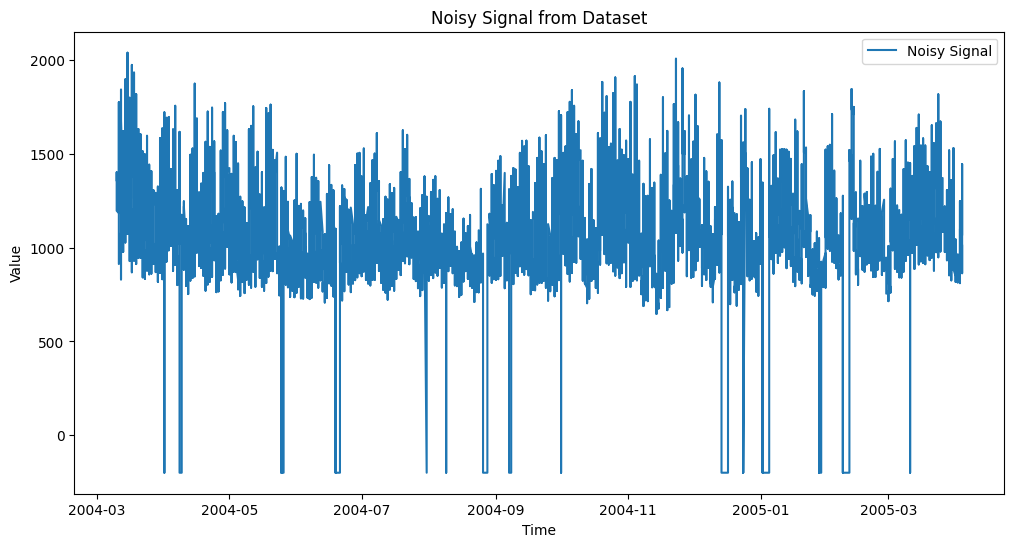

In [ ]:
# Plot the noisy signal
plt.figure(figsize=(12, 6))
plt.plot(time, noisy_signal, label='Noisy Signal')
plt.title('Noisy Signal from Dataset')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
# Step 2: Apply Kalman Filter
# Initialize Kalman Filter
kf = KalmanFilter(dim_x=2, dim_z=1)  # State vector(dim_x = 2)and  Measurement vector(dim_z = 1)

kf.x = np.array([0., 0.])  # Initial state estimate. Both the initial position and velocity are assumed to be zero. This can be adjusted based on prior knowledge about the initial state.

kf.P = np.eye(2) * 1000  # Initial state covariance which represents the uncertainty in the initial state estimate. np.eye(2) * 1000 creates a 2x2 identity matrix scaled by 1000, indicating high uncertainty in the initial estimate.

kf.F = np.array([[1, 1], [0, 1]])  # State transition matrix. The state transition matrix models how the state evolves from one time step to the next.
"""The first row [1, 1] indicates that the position estimate is updated by adding the velocity (with a time step of 1).
   The second row [0, 1] indicates that the velocity remains constant (no change in velocity)."""


kf.H = np.array([[1, 0]])  # Measurement matrix. The measurement matrix maps the true state to the measurement space. Here, it extracts the position component of the state vector for measurement.

kf.R = 1  # Measurement noise covariance; Here measurement noise is assumed to have a standard deviation of 1.

kf.Q = np.array([[1, 0], [0, 1]])  # Process noise covariance. Represents the covariance of the process noise, which models the uncertainty in the system's dynamics.
"""Q[0,0]=1: Represents the variance of the process noise affecting the position component of the state vector. This means there is some level of uncertainty in the position prediction, quantified by a variance of 1.
   Q[0,1]=0: Represents the covariance between the process noise affecting the position and the process noise affecting the velocity. A value of 0 indicates that these two noises are uncorrelated.
   Q[1,0]=0: Similarly, this is the covariance between the process noise affecting the velocity and the process noise affecting the position. A value of 0 means there is no correlation.
   Q[1,1]=1: Represents the variance of the process noise affecting the velocity component of the state vector. This means there is some level of uncertainty in the velocity prediction, quantified by a variance of 1."""

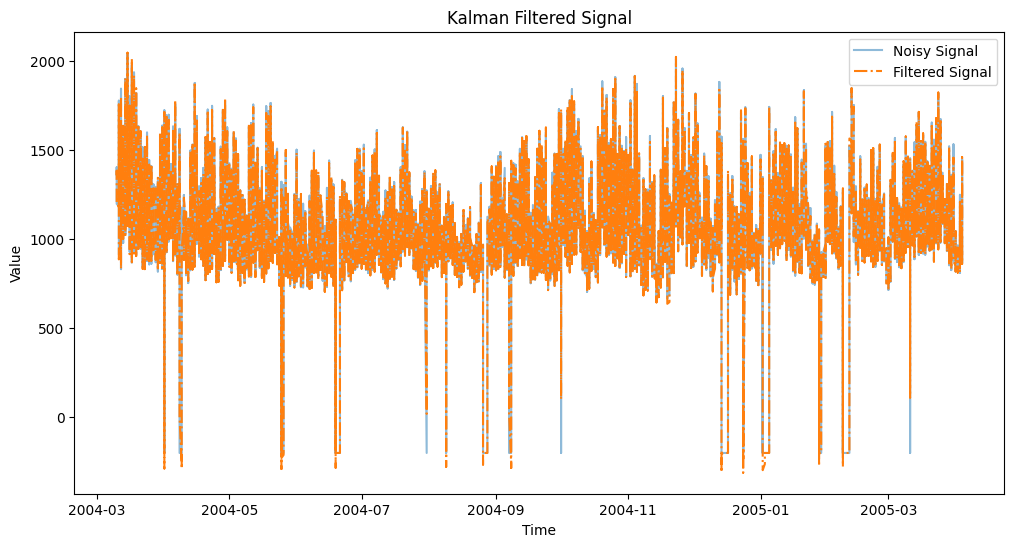

In [ ]:
# Apply Kalman filter
filtered_signal = []
for z in noisy_signal:
    kf.predict() # This step predicts the next state of the system based on the current state and the state transition matrix. It also updates the state covariance to reflect the process noise.
    kf.update(z) # This step incorporates the new measurement z to refine the state estimate. The Kalman filter computes the Kalman gain, updates the state estimate with the new measurement, and adjusts the state covariance.
    filtered_signal.append(kf.x[0]) # After updating with the measurement, the filtered state estimate (kf.x[0]) is appended to the filtered_signal list. This represents the smoothed version of the noisy signal.

# Plot the filtered signal
plt.figure(figsize=(12, 6))
plt.plot(time, noisy_signal, label='Noisy Signal', alpha=0.5)
plt.plot(time, filtered_signal, label='Filtered Signal', linestyle='-.')
plt.title('Kalman Filtered Signal')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

***BUTTERWORTH FILTER***

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import zipfile
import io
import requests
from io import StringIO

In [ ]:
# Download and load the Air Passengers dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
response = requests.get(url)
data = response.text

In [ ]:
# Read the dataset into a DataFrame
df = pd.read_csv(StringIO(data), parse_dates=['Month'], index_col='Month')

# Extract time and noisy signal
time = df.index
noisy_signal = df['Passengers']


In [ ]:
# Define Butterworth filter
def butterworth_filter(data, cutoff, fs, order=4):
  """data: The input signal or time series data that you want to filter.
     cutoff: The cutoff frequency of the Butterworth filter, above which frequencies will be attenuated.
     fs: The sampling frequency of the data
     order: The order of the Butterworth filter. Higher order means a steeper roll-off but can introduce more delay."""

  nyquist = 0.5 * fs # The Nyquist frequency is half of the sampling frequency (fs). It represents the highest frequency that can be accurately represented given the sampling rate.

  normal_cutoff = cutoff / nyquist
  # This is the normalized cutoff frequency, calculated by dividing the desired cutoff frequency by the Nyquist frequency
  # Normalizing the cutoff frequency allows it to be within the range [0, 1], where 1 corresponds to the Nyquist frequency.

  b, a = butter(order, normal_cutoff, btype='low', analog=False)
  """order: The order of the filter determines the filter's sharpness of the cutoff.
     normal_cutoff: The normalized cutoff frequency as explained earlier.
     btype='low': Specifies that we are designing a low-pass filter, which allows frequencies below the cutoff frequency to pass and attenuates frequencies above it.
     analog=False: Specifies that we are designing a digital filter, not an analog filter. This is the usual choice when working with digital signals.
     b: The numerator coefficients of the filter's transfer function.
     a: The denominator coefficients of the filter's transfer function."""

  filtered_data = filtfilt(b, a, data) # This function applies the filter to the data using forward and backward filtering to avoid phase distortion.
  return filtered_data # The function returns the filtered signal.

In [ ]:
# Filter parameters
cutoff_frequency = 0.01  # Cutoff frequency of the filter (adjust as needed)
sampling_rate = 1  # Since the data is monthly, the sampling rate is 1 per month


In [ ]:
# Apply Butterworth filter
filtered_signal = butterworth_filter(noisy_signal, cutoff_frequency, sampling_rate)

In [ ]:
# Plot original and filtered signals
plt.figure(figsize=(14, 7))

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

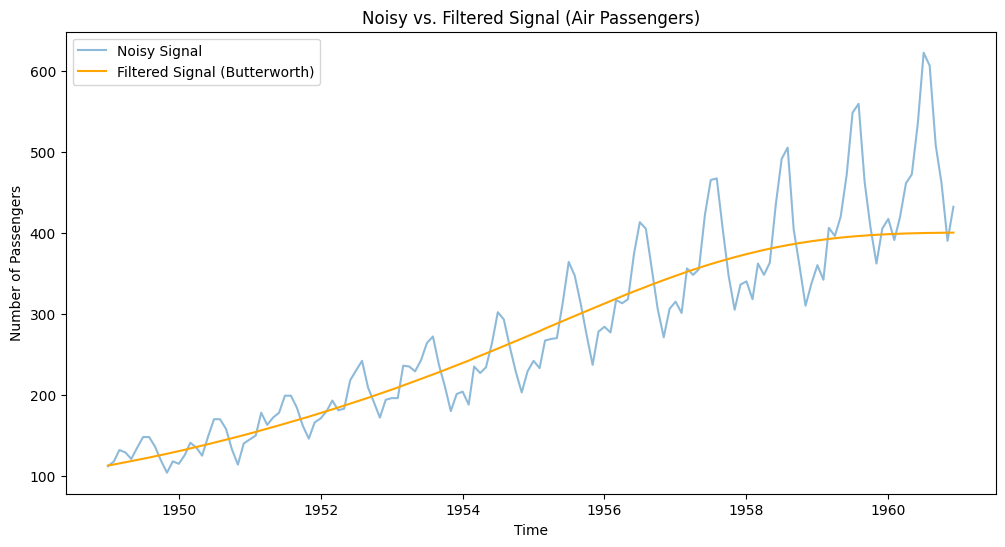

In [ ]:
import matplotlib.pyplot as plt
# Plot original and filtered signals on the same plot
plt.figure(figsize=(12, 6))
plt.plot(time, noisy_signal, label='Noisy Signal', alpha=0.5)
plt.plot(time, filtered_signal, label='Filtered Signal (Butterworth)', color='orange')
plt.title('Noisy vs. Filtered Signal (Air Passengers)')
plt.xlabel('Time')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

***HIGH PASS FILTER***

In [ ]:
def download_and_load_data(url):
    response = requests.get(url)
    data = response.text
    df = pd.read_csv(StringIO(data), parse_dates=['Month'], index_col='Month')
    return df

# Download and load the Air Passengers dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
df = download_and_load_data(url)

# Extract time and noisy signal
time = df.index
noisy_signal = df['Passengers']

In [ ]:
from scipy.signal import lfilter

In [ ]:
# Define a simple high-pass filter
def highpass_filter(data, cutoff, fs):
    # Calculate the filter coefficients
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    alpha = (1 - normal_cutoff) / (1 + normal_cutoff)
    # This parameter is used to define the filter coefficients. It determines how much of the input signal is allowed to pass through versus how much is filtered out.

    b = [alpha, -alpha]
    # These coefficients define the numerator of the filter’s transfer function.
    # The numerator coefficients [alpha, -alpha] represent a difference equation that emphasizes the high-frequency components of the signal.

    a = [1, -alpha]
    # These coefficients define the denominator of the filter’s transfer function. They help in shaping the frequency response of the filter.
    # 1: Represents the current input sample.
    # -alpha: This coefficient is used to determine the feedback in the filter. It adjusts how much of the previous output affects the current output.

    # Apply the filter
    filtered_data = lfilter(b, a, data)
    return filtered_data

In [ ]:
# Filter parameters
cutoff_frequency = 0.1  # Cutoff frequency of the filter (adjust as needed)
sampling_rate = 1  # Since the data is monthly, the sampling rate is 1 per month

In [ ]:
# Apply High-pass filter
filtered_signal = highpass_filter(noisy_signal, cutoff_frequency, sampling_rate)

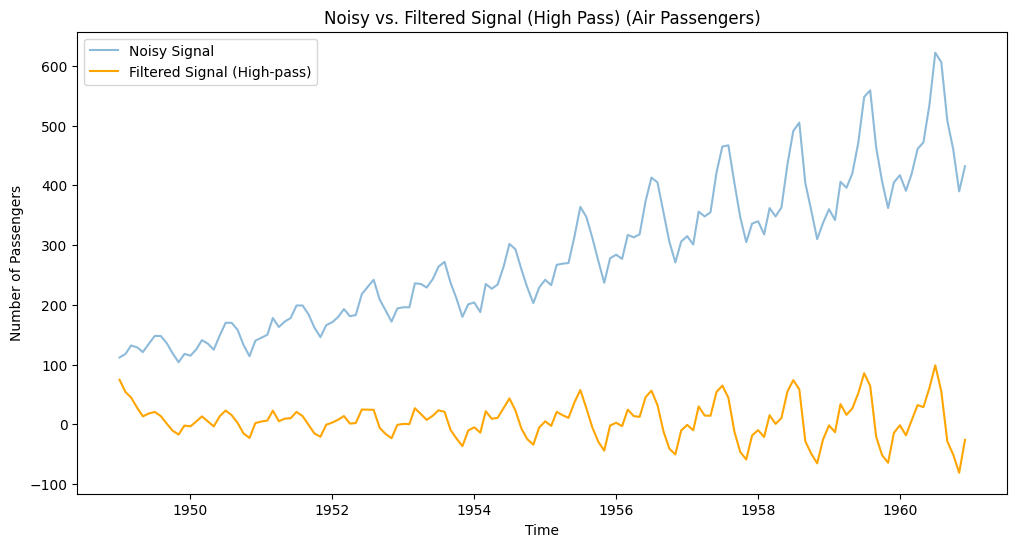

In [ ]:
import matplotlib.pyplot as plt
# Plot original and filtered signals on the same plot
plt.figure(figsize=(12, 6))
plt.plot(time, noisy_signal, label='Noisy Signal', alpha=0.5)
plt.plot(time, filtered_signal, label='Filtered Signal (High-pass)', color='orange')
plt.title('Noisy vs. Filtered Signal (High Pass) (Air Passengers)')
plt.xlabel('Time')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

***LOW PASS FILTER***

In [ ]:
# Function to download and load the dataset
def download_and_load_data(url):
    response = requests.get(url)
    data = response.text
    df = pd.read_csv(StringIO(data), parse_dates=['Month'], index_col='Month')
    return df

# Download and load the Air Passengers dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
df = download_and_load_data(url)

# Extract time and noisy signal
time = df.index
noisy_signal = df['Passengers']

In [ ]:
# Define a simple low-pass filter
def lowpass_filter(data, cutoff, fs):
    # Calculate the filter coefficients
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    alpha = normal_cutoff / (1 + normal_cutoff)

    b = [alpha] # This is purely with respect to first order low pass filter
    a = [1, alpha - 1] # This is purely with respect to first order low pass filter

    # Apply the filter
    filtered_data = lfilter(b, a, data)
    return filtered_data

In [ ]:
# Filter parameters
cutoff_frequency = 0.1  # Cutoff frequency of the filter (adjust as needed)
sampling_rate = 1  # Since the data is monthly, the sampling rate is 1 per month

# Apply Low-pass filter
filtered_signal = lowpass_filter(noisy_signal, cutoff_frequency, sampling_rate)

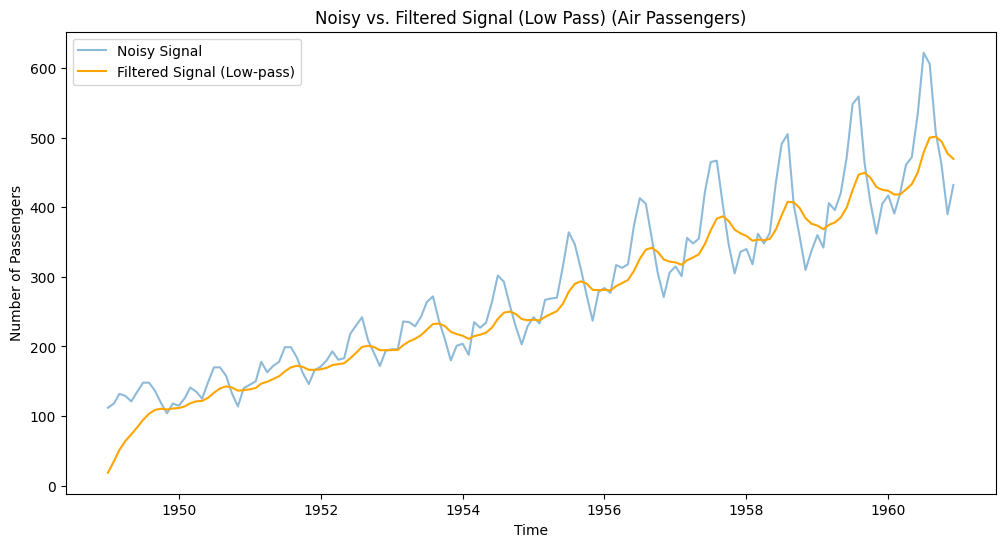

In [ ]:
import matplotlib.pyplot as plt
# Plot original and filtered signals on the same plot
plt.figure(figsize=(12, 6))
plt.plot(time, noisy_signal, label='Noisy Signal', alpha=0.5)
plt.plot(time, filtered_signal, label='Filtered Signal (Low-pass)', color='orange')
plt.title('Noisy vs. Filtered Signal (Low Pass) (Air Passengers)')
plt.xlabel('Time')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()